In [1]:
%load_ext autoreload
%autoreload 2
%cd '../HOTS'
%matplotlib inline

/home/antoine/homhots/HOTS/HOTS


In [2]:
import tonic
from mix_TimeSurface import TimeSurface
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import os
import pickle
import datetime
from mix_Network import *


def printfig(fig, name):
    dpi_exp = None
    bbox = 'tight'
    path = '../../paper/5f22d412742c360001c92b46/fig/'
    fig.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox)

# Stream.png

In [24]:
learningset = tonic.datasets.POKERDVS(save_to='../Data/', train = False,
                                transform=None)
loader = tonic.datasets.DataLoader(learningset, shuffle=True)

Using downloaded and verified file: ../Data/pips_test.tar.gz
Extracting ../Data/pips_test.tar.gz to ../Data/


In [25]:
print(learningset)

Dataset POKERDVS
    Number of datapoints: 20
    Root location: ../Data/


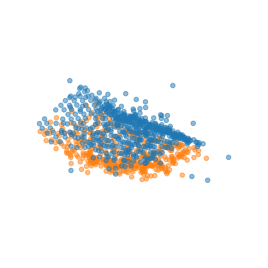

In [33]:
        target_event = 1000
        X_on = []
        Y_on = []
        T_on = []
        X_off = []
        Y_off = []
        T_off = []
        iev = 100
        events, target = next(iter(loader))
        while iev<target_event:
            x,y,t,p = events[0][iev][learningset.ordering.find("x")].item(), \
                    events[0][iev][learningset.ordering.find("y")].item(), \
                    events[0][iev][learningset.ordering.find("t")].item(), \
                    events[0][iev][learningset.ordering.find("p")].item()
            if p:
                X_on.append(x)
                Y_on.append(abs(learningset.sensor_size[1]-y))
                T_on.append(t)
            else:
                X_off.append(x)
                Y_off.append(abs(learningset.sensor_size[1]-y))
                T_off.append(t)
            iev+=1
        fig = plt.figure(figsize=(10,5))
        sub1 = fig.add_subplot(1,2,1, projection="3d")
        sub1.scatter(T_on, X_on, Y_on, cmap= plt.cm.plasma, alpha=0.5)
        sub1.scatter(T_off, X_off, Y_off, cmap= plt.cm.plasma, alpha=0.5)
        #sub1.arrow([0,max(T_off)], [0,0], [0,0])
        sub1.view_init(10,-40)
        sub1.grid(b = None)
        sub1.set_xlabel('time')
        sub1.axis('off')
        plt.show()

In [34]:
printfig(fig, 'stream.png')

# Flux.png

In [35]:
learningset = tonic.datasets.NMNIST(save_to='../Data/', train = False,
                                transform=None)
loader = tonic.datasets.DataLoader(learningset, shuffle=True)

Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


In [36]:
target_event = 2000
TS = TimeSurface(R=2,tau=5*10e3,camsize=[34,34])
events, target = next(iter(loader))
flxT = TS.spatpmat.copy()
iev = 0
while iev<target_event:
    x,y,t,p = events[0][iev][learningset.ordering.find("x")].item(), \
                events[0][iev][learningset.ordering.find("y")].item(), \
                events[0][iev][learningset.ordering.find("t")].item(), \
                events[0][iev][learningset.ordering.find("p")].item(),
    flxT[p,x,y] = t
    ts, activ = TS.addevent(x,y,t,p)
    iev+=1

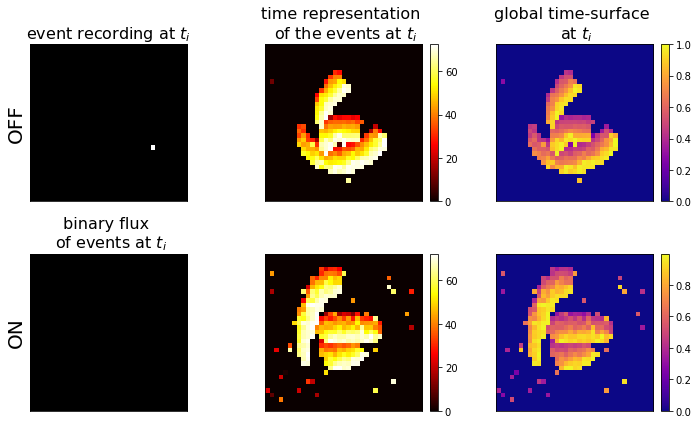

In [37]:
polaritiz = ['OFF','ON']
gamma = 1
fig, axs = plt.subplots(2,3,figsize=(10,6))

Ti = np.zeros(learningset.sensor_size)
singev = axs[abs(p-1),0].imshow(Ti.T, cmap='gray')
axs[abs(p-1),0].set_title('binary flux \n of events at $t_i$', fontsize=16)
axs[abs(p-1),0].set_ylabel(f'{polaritiz[abs(p-1)]}', fontsize=20)
axs[abs(p-1),0].set_xticks(())
axs[abs(p-1),0].set_yticks(())

Ti[x,y] = 1
singev = axs[p,0].imshow(Ti.T, cmap='gray')
#axs[p,0].set_title('binary flux of events at $t_i$', fontsize=16) #for NN
if p==0:
    axs[p,0].set_title('event recording at $t_i$', fontsize=16)
axs[p,0].set_ylabel(f'{polaritiz[p]}', fontsize=20)
axs[p,0].set_xticks(())
axs[p,0].set_yticks(())

for p in [0,1]:
    T = axs[p,1].imshow(flxT[p].T*1e-3, cmap='hot')
    #axs[p,1].set_title('T flux at $t_i$ (in $ms$)', fontsize=16) #for NN
    if p==0:
        axs[p,1].set_title('time representation \n of the events at $t_i$', fontsize=16)
    axs[p,1].set_xticks(())
    axs[p,1].set_yticks(())
    plt.colorbar(T, ax=axs[p,1], fraction=0.046, pad=0.04);
    
    S = axs[p,2].imshow(TS.spatpmat[p].T, cmap=plt.cm.plasma)
    #axs[p,2].set_title('S flux at $t_i$', fontsize=16) #for NN
    if p==0:
        axs[p,2].set_title('global time-surface \n at $t_i$', fontsize=16)
    axs[p,2].set_xticks(())
    axs[p,2].set_yticks(())
    cbar = plt.colorbar(S, ax=axs[p,2], fraction=0.046, pad=0.04);
    #cbar.set_label(fonsize=16)
    
fig.tight_layout()

In [38]:
printfig(fig, 'flux.png')

# Layers.png

In [3]:
dataset = 'nmnist'
records_path = '../Records'
timestr = datetime.datetime.now().date().isoformat()
timestr = '2021-01-06'

%mkdir -p ../Records
%mkdir -p ../Records/EXP_03_NMNIST

homeo = True
sigma = 1
pooling = False
homeinv = False
jitter = False
tau = 5
nb_train = 500
nb_test = 100
krnlinit = 'rdn'
nblay = 3
nbclust = 4
filt = 2

def makehisto(filt, tau, krnlinit, nblay, nbclust, homeo, records_path, timestr, dataset, sigma, homeinv, jitter, nb_train, nb_test):
    if pooling:
        hotshom = poolingnetwork(krnlinit=krnlinit, filt=filt, tau=tau, nblay=nblay, nbclust=nbclust, homeo=homeo, sigma=sigma, homeinv=homeinv, jitter=jitter)
    else:
        hotshom = network(krnlinit=krnlinit, filt=filt, tau=tau, nblay=nblay, nbclust=nbclust, homeo=homeo, sigma=sigma, homeinv=homeinv, jitter=jitter)
    arch = [hotshom.L[i].kernel.shape[1] for i in range(len(hotshom.L))]
    fname = f'{records_path}/EXP_03_NMNIST/{timestr}_hots_{dataset}_{arch}_{krnlinit}_{tau}_{homeo}_{sigma}_{homeinv}_{jitter}'
    print(fname)
    if not os.path.isfile(fname+'_model.pkl'):
        loaderhom, order = hotshom.learningall(dataset=dataset)
        with open(fname+'_model.pkl', 'wb') as file:
            pickle.dump([hotshom, loaderhom, order], file, pickle.HIGHEST_PROTOCOL)
    else:
        with open(fname+'_model.pkl', 'rb') as file:
            hotshom, loaderhom, order = pickle.load(file)
    fig = hotshom.plotlayer()
    if not os.path.isfile(fname+f'_histo_{nb_train}_{nb_test}.pkl'):       
        trainmaphom, loaderhom, _ = hotshom.running(loaderhom, order, nb_digit = nb_train)
        testmaphom, loaderhom, _ = hotshom.running(loaderhom, order, nb_digit = nb_test)
        with open(fname+f'_histo_{nb_train}_{nb_test}.pkl', 'wb') as file:
            pickle.dump([trainmaphom, testmaphom], file, pickle.HIGHEST_PROTOCOL)
    else:
        with open(fname+f'_histo_{nb_train}_{nb_test}.pkl', 'rb') as file:
            trainmaphom, testmaphom = pickle.load(file)
    histoscore(trainmaphom,testmaphom)
    return fig, hotshom, loaderhom, order, trainmaphom, testmaphom

../Records/EXP_03_NMNIST/2021-01-06_hots_nmnist_[4, 8, 16]_rdn_5_True_1_False_False


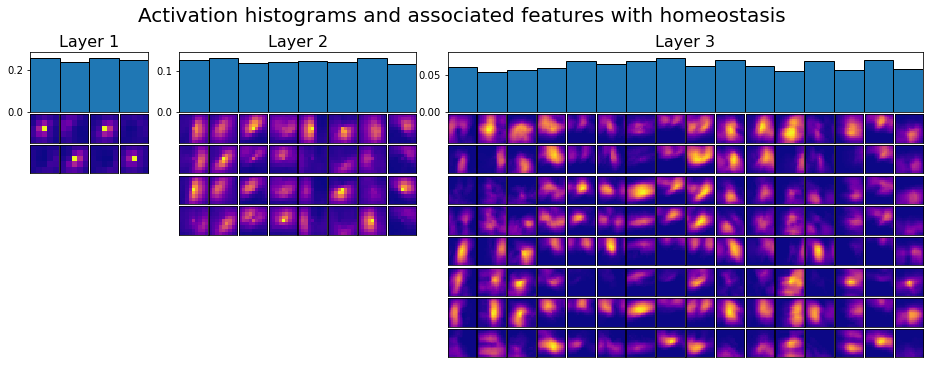

-----------------------------------------------SCORES-----------------------------------------------
Classification scores with HOTS measures: bhatta = 86.0% - eucli = 84.0% - norm = 84.0%
Classification scores with kNN: 3-NN = 83.0% - 6-NN = 81.0%
Classification scores with entropy: Kullback-Leibler = 86.0% - Jensen-Shannon = 86.0%
----------------------------------------------------------------------------------------------------


In [40]:
fig, hotshom, loaderhom, order, trainmaphom, testmaphom = makehisto(filt, tau, krnlinit, nblay, nbclust, homeo, records_path, timestr, dataset, sigma, homeinv, jitter, nb_train, nb_test);

In [41]:
printfig(fig, 'layerwiz.png')

../Records/EXP_03_NMNIST/2021-01-06_hots_nmnist_[4, 8, 16]_rdn_5_False_1_False_False


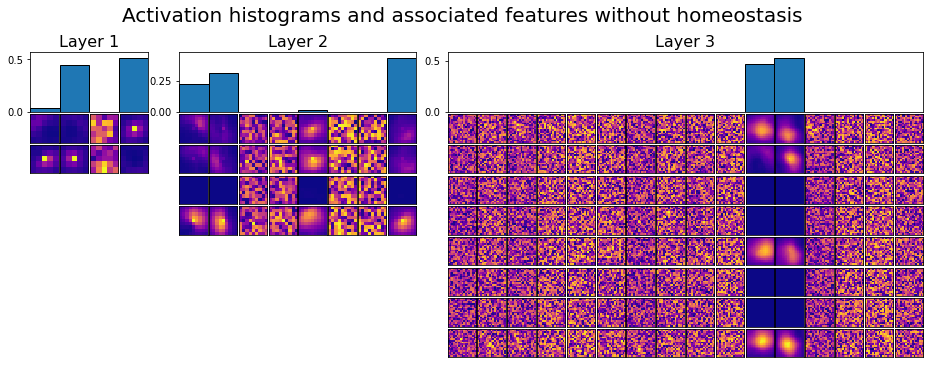

-----------------------------------------------SCORES-----------------------------------------------
Classification scores with HOTS measures: bhatta = 33.0% - eucli = 28.000000000000004% - norm = 28.000000000000004%
Classification scores with kNN: 3-NN = 24.0% - 6-NN = 22.0%
Classification scores with entropy: Kullback-Leibler = 32.0% - Jensen-Shannon = 33.0%
----------------------------------------------------------------------------------------------------


In [42]:
homeo = False
fig, hotshom, loaderhom, order, trainmaphom, testmaphom = makehisto(filt, tau, krnlinit, nblay, nbclust, homeo, records_path, timestr, dataset, sigma, homeinv, jitter, nb_train, nb_test);

In [43]:
printfig(fig, 'layerwizout.png')

# Jitter.png

In [3]:
dataset = 'nmnist'
records_path = '../Records'
timestr = '2021-02-08'
homeo = True
sigma = None
pooling = False
homeinv = False
jitonic = [None,None] #[temporal, spatial]
jitter = False
tau = 5
nb_train = 500
nb_test = 100
krnlinit = 'rdn'
nblay = 3
nbclust = 4
filt = 2

In [4]:
hotshom = network(krnlinit=krnlinit, filt=filt, tau=tau, nblay=nblay, nbclust=nbclust, homeo=homeo, sigma=sigma, homeinv=homeinv, jitter=jitter)
hotshom = hotshom.learningall(dataset=dataset)
trainhistomap = hotshom.running(nb_digit=nb_train)

../Records/nmnist/models/2021-02-08_lagorce_rdn_None_True_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8].pkl


In [9]:
score_S = []
score_SH = []
spa_jit = []
tim_jit = []
score_T = []
score_TH = []

for hom in [True, False]:
    for l in range(len(hotshom.L)):
        hotshom.L[l].homeo=hom
        
    print(f'Homeostasis -> {hom}')

    for i in np.arange(0,30,0.5):
        i = round(i,1)
        jitonic = [None,i]
        testhistomap = hotshom.running(train=False, nb_digit=nb_test, jitonic=jitonic)
        JS_score = histoscore(trainhistomap,testhistomap, verbose = False)
        print(f'loading... - spatial jitter = {i} - score = {JS_score}',end='\r')
        if hom:
            score_SH.append(JS_score)
            spa_jit.append(i)
        else:
            score_S.append(JS_score)
        
    for j in np.arange(0,30000,500):
        j = round(j,1)
        jitonic = [j,None]
        testhistomap = hotshom.running(train=False, nb_digit=nb_test, jitonic=jitonic)
        JS_score = histoscore(trainhistomap,testhistomap, verbose = False)
        print(f'loading... - temporal jitter = {j} - score = {JS_score}',end='\r')
        if hom:
            score_TH.append(JS_score)
            tim_jit.append(j)
        else:
            score_T.append(JS_score)

Homeostasis -> True
Homeostasis -> Falsel jitter = 29500 - score = 0.14


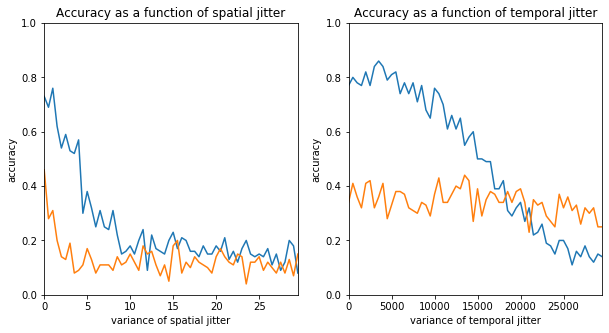

In [10]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].plot(spa_jit,score_SH,
                      spa_jit,score_S)
axs[0].axis([0,max(spa_jit),0,1])
axs[0].set_xlabel('variance of spatial jitter')
axs[0].set_ylabel('accuracy')
axs[0].set_title('Accuracy as a function of spatial jitter');

axs[1].plot(tim_jit,score_TH,
                      tim_jit,score_T)
axs[1].axis([0,max(tim_jit),0,1])
axs[1].set_xlabel('variance of temporal jitter')
axs[1].set_ylabel('accuracy')
axs[1].set_title('Accuracy as a function of temporal jitter');

In [11]:
printfig(fig, 'jitter.png')